In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

from mlxtend.classifier import EnsembleVoteClassifier

In [2]:
data_main = pd.read_excel('IMDb Dataset')
data_pos_select = data_main[data_main['sentiment'] == 'positive']
data_neg_select = data_main[data_main['sentiment'] == 'negative']
data = pd.concat([data_pos_select, data_neg_select])

## Cleaning the text

In [3]:
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)

In [4]:
def cleaning_text(text):

    text_string = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A).strip()
    token_string = word_tokenize(text_string)
    stemmer = PorterStemmer()
    token_string_stem = [stemmer.stem(word) for word in token_string if word not in stop_words]

    return ' '.join(token_string_stem)

In [5]:
data['review'] = data['review'].apply(cleaning_text)
data['sentiment'] = data['sentiment'].apply(lambda sentiment: int(sentiment == 'positive'))

In [6]:
train, test = train_test_split(data, test_size=0.1)

In [7]:
vectorizer = CountVectorizer(max_features=10000)
train_mat = vectorizer.fit_transform(train['review'].values)
test_mat = vectorizer.transform(test['review'].values)
vectorizer.get_feature_names()

['10',
 'aamir',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct',
 'abe',
 'abigail',
 'abil',
 'abl',
 'abli',
 'aboard',
 'abomin',
 'aborigin',
 'abort',
 'abound',
 'about',
 'aboutbr',
 'abov',
 'abr',
 'abraham',
 'abroad',
 'abrupt',
 'abruptli',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abstract',
 'absurd',
 'absurdli',
 'abu',
 'abund',
 'abus',
 'abysm',
 'abyss',
 'academ',
 'academi',
 'accent',
 'accentu',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accolad',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accustom',
 'ace',
 'ach',
 'achiev',
 'acid',
 'acknowledg',
 'acquaint',
 'acquir',
 'acquit',
 'acr',
 'acrobat',
 'across',
 'act',
 'actbr',
 'actingbr',
 'action',
 'actionadventur',
 'actionbr',
 'actionpack',
 'activ',
 'activist',
 'actor',
 'actorbr',
 'actorsactress',
 'actorsbr',
 'actress',
 'actual',
 'ad'

## Training and Testing the data

### Weighted Sentiment Sums

In [8]:
class WeightedWordClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y):
        word_sentiment = {}

        for index, row in train.iterrows():

            line, sentiment = row['review'], row['sentiment']

            for word in line.split():

                try:
                    word_sentiment[word][0] = word_sentiment[word][0] + 1 if int(sentiment) == 1 else word_sentiment[word][0] - 1
                except:
                    word_sentiment[word] = [1, 0] if int(sentiment) == 1 else [-1, 0]
                finally:
                    word_sentiment[word][1] += 1

        self.word_weighted_sentiment = {word: word_sentiment[word][0] / word_sentiment[word][1] for word in word_sentiment.keys()}

    def predict(self, X):
        word_weighted_y_pred = []

        for data in test['review'].values:

            words = data.split()
            sentiment = 0

            for word in words:
                sentiment += self.word_weighted_sentiment.get(word, 0)

            word_weighted_y_pred.append(1 if sentiment >= 0 else 0)

        return word_weighted_y_pred

In [9]:
WWClassifier = WeightedWordClassifier()

In [10]:
WWClassifier.fit(train, train['sentiment'].values)

In [11]:
word_weighted_y_pred = WWClassifier.predict(train)

In [12]:
Word_Weighted_accuracy = metrics.accuracy_score(test['sentiment'].values, word_weighted_y_pred)

Word_Weighted_precision, Word_Weighted_recall, Word_Weighted_f_score, Word_Weighted_support = metrics.precision_recall_fscore_support(test['sentiment'].values,
                                                                                                                                      word_weighted_y_pred, 
                                                                                                                                      average='binary', 
                                                                                                                                      labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, word_weighted_y_pred, labels=[0, 1]))
print('Accuracy Score', Word_Weighted_accuracy)
print('Precision', Word_Weighted_precision)
print('Recall', Word_Weighted_recall)
print('F-Score', Word_Weighted_f_score)

Confusion Matrix :
[[2152  339]
 [ 381 2128]]
Accuracy Score 0.856
Precision 0.8625861370085124
Recall 0.8481466719808689
F-Score 0.855305466237942


### Gaussian Naive Bayes

In [13]:
GNBClassifer = GaussianNB()

In [14]:
GNBClassifer.fit(train_mat.toarray(), train['sentiment'].values)

GaussianNB(priors=None, var_smoothing=1e-09)

In [15]:
GNB_y_pred = GNBClassifer.predict(test_mat.toarray())

In [16]:
GNB_accuracy = metrics.accuracy_score(test['sentiment'].values, GNB_y_pred)

GNB_precision, GNB_recall, GNB_f_score, GNB_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              GNB_y_pred,
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, GNB_y_pred, labels=[0, 1]))
print('Accuracy Score', GNB_accuracy)
print('Precision', GNB_precision)
print('Recall', GNB_recall)
print('F-Score', GNB_f_score)

Confusion Matrix :
[[2151  340]
 [1119 1390]]
Accuracy Score 0.7082
Precision 0.8034682080924855
Recall 0.5540055799123157
F-Score 0.6558150507195094


### Multinomial Naive Bayes

In [17]:
MNBClassifer = MultinomialNB()

In [18]:
MNBClassifer.fit(train_mat, train['sentiment'].values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
MNB_y_pred = MNBClassifer.predict(test_mat)

In [20]:
MNB_accuracy = metrics.accuracy_score(test['sentiment'].values, MNB_y_pred)

MNB_precision, MNB_recall, MNB_f_score, MNB_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              MNB_y_pred, 
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, MNB_y_pred, labels=[0, 1]))
print('Accuracy Score', MNB_accuracy)
print('Precision', MNB_precision)
print('Recall', MNB_recall)
print('F-Score', MNB_f_score)

Confusion Matrix :
[[2166  325]
 [ 410 2099]]
Accuracy Score 0.853
Precision 0.865924092409241
Recall 0.836588282184137
F-Score 0.8510034461787958


### Bernoulli Naive Bayes

In [21]:
BNBClassifer = BernoulliNB()

In [22]:
BNBClassifer.fit(train_mat, train['sentiment'].values)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [23]:
BNB_y_pred = BNBClassifer.predict(test_mat)

In [24]:
BNB_accuracy = metrics.accuracy_score(test['sentiment'].values, BNB_y_pred)

BNB_precision, BNB_recall, BNB_f_score, BNB_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              BNB_y_pred, 
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, BNB_y_pred, labels=[0, 1]))
print('Accuracy Score', BNB_accuracy)
print('Precision', BNB_precision)
print('Recall', BNB_recall)
print('F-Score', BNB_f_score)

Confusion Matrix :
[[2148  343]
 [ 378 2131]]
Accuracy Score 0.8558
Precision 0.8613581244947454
Recall 0.8493423674770825
F-Score 0.8553080473610275


### Complement Naive Bayes

In [25]:
CNBClassifer = ComplementNB()

In [26]:
CNBClassifer.fit(train_mat, train['sentiment'].values)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [27]:
CNB_y_pred = CNBClassifer.predict(test_mat)

In [28]:
CNB_accuracy = metrics.accuracy_score(test['sentiment'].values, CNB_y_pred)

CNB_precision, CNB_recall, CNB_f_score, CNB_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              CNB_y_pred, 
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, CNB_y_pred, labels=[0, 1]))
print('Accuracy Score', CNB_accuracy)
print('Precision', CNB_precision)
print('Recall', CNB_recall)
print('F-Score', CNB_f_score)

Confusion Matrix :
[[2165  326]
 [ 410 2099]]
Accuracy Score 0.8528
Precision 0.8655670103092783
Recall 0.836588282184137
F-Score 0.8508309687880016


### Decision Tree Classifier

In [29]:
DTClassifier = DecisionTreeClassifier()

In [30]:
DTClassifier.fit(train_mat, train['sentiment'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [31]:
DT_y_pred = DTClassifier.predict(test_mat)

In [32]:
DT_accuracy = metrics.accuracy_score(test['sentiment'].values, DT_y_pred)

DT_precision, DT_recall, DT_f_score, DT_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                          DT_y_pred, 
                                                                                          average='binary', 
                                                                                          labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, DT_y_pred, labels=[0, 1]))
print('Accuracy Score', DT_accuracy)
print('Precision', DT_precision)
print('Recall', DT_recall)
print('F-Score', DT_f_score)

Confusion Matrix :
[[1854  637]
 [ 705 1804]]
Accuracy Score 0.7316
Precision 0.7390413764850471
Recall 0.7190115583897967
F-Score 0.7288888888888889


### Random Forest Classifier

In [33]:
RFClassifier = RandomForestClassifier()

In [34]:
RFClassifier.fit(train_mat, train['sentiment'].values)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
RF_y_pred = RFClassifier.predict(test_mat)

In [36]:
RF_accuracy = metrics.accuracy_score(test['sentiment'].values, RF_y_pred)

RF_precision, RF_recall, RF_f_score, RF_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                          RF_y_pred, 
                                                                                          average='binary', 
                                                                                          labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, RF_y_pred, labels=[0, 1]))
print('Accuracy Score', RF_accuracy)
print('Precision', RF_precision)
print('Recall', RF_recall)
print('F-Score', RF_f_score)

Confusion Matrix :
[[2138  353]
 [ 711 1798]]
Accuracy Score 0.7872
Precision 0.8358902835890284
Recall 0.7166201673973694
F-Score 0.7716738197424892


### Logistic Regression

In [37]:
LogClassifier = LogisticRegression(solver='liblinear')

In [38]:
LogClassifier.fit(train_mat, train['sentiment'].values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
Log_y_pred = LogClassifier.predict(test_mat)

In [40]:
Log_accuracy = metrics.accuracy_score(test['sentiment'].values, Log_y_pred)

Log_precision, Log_recall, Log_f_score, Log_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              Log_y_pred, 
                                                                                              average='binary', 
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, Log_y_pred, labels=[0, 1]))
print('Accuracy Score', Log_accuracy)
print('Precision', Log_precision)
print('Recall', Log_recall)
print('F-Score', Log_f_score)

Confusion Matrix :
[[2179  312]
 [ 302 2207]]
Accuracy Score 0.8772
Precision 0.8761413259229853
Recall 0.8796333200478278
F-Score 0.8778838504375498


### K-Nearest Neighbour

In [41]:
KNNClassifier = KNeighborsClassifier()

In [42]:
KNNClassifier.fit(train_mat, train['sentiment'].values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [43]:
KNN_y_pred = KNNClassifier.predict(test_mat)

In [44]:
KNN_accuracy = metrics.accuracy_score(test['sentiment'].values, KNN_y_pred)

KNN_precision, KNN_recall, KNN_f_score, KNN_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              KNN_y_pred, 
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, KNN_y_pred, labels=[0, 1]))
print('Accuracy Score', KNN_accuracy)
print('Precision', KNN_precision)
print('Recall', KNN_recall)
print('F-Score', KNN_f_score)

Confusion Matrix :
[[1719  772]
 [1065 1444]]
Accuracy Score 0.6326
Precision 0.6516245487364621
Recall 0.575528098844161
F-Score 0.6112169312169312


### Support Vector Machine (SVM)

In [45]:
SVClassifer = SVC(gamma='scale')

In [46]:
SVClassifer.fit(train_mat, train['sentiment'].values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
SVC_y_pred = SVClassifer.predict(test_mat)

In [48]:
SVC_accuracy = metrics.accuracy_score(test['sentiment'].values, SVC_y_pred)

SVC_precision, SVC_recall, SVC_f_score, SVC_support = metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                              SVC_y_pred, 
                                                                                              average='binary',
                                                                                              labels=[0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, SVC_y_pred, labels=[0, 1]))
print('Accuracy Score', SVC_accuracy)
print('Precision', SVC_precision)
print('Recall', SVC_recall)
print('F-Score', SVC_f_score)

Confusion Matrix :
[[2169  322]
 [ 217 2292]]
Accuracy Score 0.8922
Precision 0.8768171384850804
Recall 0.913511359107214
F-Score 0.8947882100331837


## Graph to compare

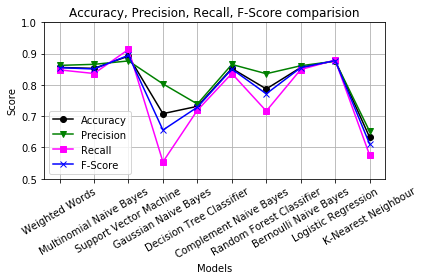

In [49]:
models = np.array(['Weighted Words', 'Multinomial Naive Bayes', 'Support Vector Machine', 'Gaussian Naive Bayes', 'Decision Tree Classifier', 'Complement Naive Bayes', 'Random Forest Classifier', 'Bernoulli Naive Bayes', 'Logistic Regression', 'K-Nearest Neighbour'])
plt.plot(models, [Word_Weighted_accuracy, MNB_accuracy, SVC_accuracy, GNB_accuracy, DT_accuracy, CNB_accuracy, RF_accuracy, BNB_accuracy, Log_accuracy, KNN_accuracy], 
         color='k', marker='o', label='Accuracy')
plt.plot(models, [Word_Weighted_precision, MNB_precision, SVC_precision, GNB_precision, DT_precision, CNB_precision, RF_precision, BNB_precision, Log_precision, KNN_precision], 
         color='green', marker='v', label='Precision')
plt.plot(models, [Word_Weighted_recall, MNB_recall, SVC_recall, GNB_recall, DT_recall, CNB_recall, RF_recall, BNB_recall, Log_recall, KNN_recall], 
         color='magenta', marker='s', label='Recall')
plt.plot(models, [Word_Weighted_f_score, MNB_f_score, SVC_f_score, GNB_f_score, DT_f_score, CNB_f_score, RF_f_score, BNB_f_score, Log_f_score, KNN_f_score], 
         color='blue', marker='x', label='F-Score')
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Accuracy, Precision, Recall, F-Score comparison")
plt.legend()
plt.grid()
plt.xticks(rotation = 30)
plt.ylim(0.5, 1)
plt.tight_layout()
plt.savefig('Classifier Comparison.svg', format='svg', dpi = 300)
plt.show()

### Ensemble

In [50]:
estimators = [LogClassifier, WWClassifier, SVClassifer, BNBClassifer]

In [51]:
Ensemble = EnsembleVoteClassifier(estimators, voting='hard', weights=[Log_accuracy, Word_Weighted_accuracy, SVC_accuracy, BNB_accuracy], refit=False)

In [52]:
Ensemble.fit(train_mat, train['sentiment'].values)

EnsembleVoteClassifier(clfs=[LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                             WeightedWordClassifier(),
                             SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='scale', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 rando

In [53]:
Ensemble_y_pred = Ensemble.predict(test_mat)

In [54]:
Ensemble_accuracy = metrics.accuracy_score(test['sentiment'].values, Ensemble_y_pred)

Ensemble_precision, Ensemble_recall, Ensemble_f_score, Ensemble_support= metrics.precision_recall_fscore_support(test['sentiment'].values, 
                                                                                                                 Ensemble_y_pred, 
                                                                                                                 average = 'binary', 
                                                                                                                 labels = [0, 1])

print('Confusion Matrix :')
print(metrics.confusion_matrix(test['sentiment'].values, Ensemble_y_pred, labels = [0, 1]))
print('Accuracy Score', Ensemble_accuracy)
print('Precision', Ensemble_precision)
print('Recall', Ensemble_recall)
print('F-Score', Ensemble_f_score)

Confusion Matrix :
[[2201  290]
 [ 231 2278]]
Accuracy Score 0.8958
Precision 0.8870716510903427
Recall 0.9079314467915505
F-Score 0.89738034272208


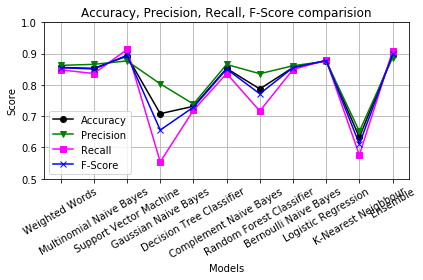

In [55]:
models = np.array(['Weighted Words', 'Multinomial Naive Bayes', 'Support Vector Machine', 'Gaussian Naive Bayes', 'Decision Tree Classifier', 'Complement Naive Bayes', 'Random Forest Classifier', 'Bernoulli Naive Bayes', 'Logistic Regression', 'K-Nearest Neighbour', 'Ensemble'])
plt.plot(models, [Word_Weighted_accuracy, MNB_accuracy, SVC_accuracy, GNB_accuracy, DT_accuracy, CNB_accuracy, RF_accuracy, BNB_accuracy, Log_accuracy, KNN_accuracy, Ensemble_accuracy], 
         color='k', marker='o', label='Accuracy')
plt.plot(models, [Word_Weighted_precision, MNB_precision, SVC_precision, GNB_precision, DT_precision, CNB_precision, RF_precision, BNB_precision, Log_precision, KNN_precision, Ensemble_precision], 
         color='green', marker='v', label='Precision')
plt.plot(models, [Word_Weighted_recall, MNB_recall, SVC_recall, GNB_recall, DT_recall, CNB_recall, RF_recall, BNB_recall, Log_recall, KNN_recall, Ensemble_recall], 
         color='magenta', marker='s', label='Recall')
plt.plot(models, [Word_Weighted_f_score, MNB_f_score, SVC_f_score, GNB_f_score, DT_f_score, CNB_f_score, RF_f_score, BNB_f_score, Log_f_score, KNN_f_score, Ensemble_f_score], 
         color='blue', marker='x', label='F-Score')
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Accuracy, Precision, Recall, F-Score comparison")
plt.legend()
plt.grid()
plt.xticks(rotation=30)
plt.ylim(0.5, 1)
plt.tight_layout()
plt.savefig('Ensemble Comparison.svg', format='svg', dpi=300)
plt.show()